In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a72e4742-cf8b-7bb0-0df4-454deb73fb77)


In [3]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

# For image resizing
import cv2 as cv
print( f"OpenCV {cv.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

NumPy 1.21.6

OpenCV 4.6.0

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


# Prepare Data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras_preprocessing.image import ImageDataGenerator

In [5]:
data_path = pathlib.Path(r"/content/drive/MyDrive/Colab Notebooks/CNN/data")

all_images = list(data_path.glob(r'*/*.jpg')) + list(data_path.glob(r'*/*.jpeg')) + list(data_path.glob(r'*/*.png'))

images = []
labels = []

for item in all_images:
    path = os.path.normpath(item)
    splits = path.split(os.sep)
    if 'GT' not in splits[-2]:
        images.append(item)
        label = splits[-2]
        labels.append(label)

In [6]:
image_pathes = pd.Series(images).astype(str)
labels = pd.Series(labels)

dataframe =pd.concat([image_pathes, labels], axis=1)

dataframe.columns = ['images', 'labels']

dataframe.head()

,images,labels
0,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Chanthaburi
1,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Chanthaburi
2,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Chanthaburi
3,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Chanthaburi
4,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Chanthaburi


In [7]:
dataframe.groupby('labels').count()

,images
labels,
Amnat Charoen,21
Ang Thong,19
Bangkok,28
Bueng Kan,24
Buri Ram,23
...,...
Udon Thani,36
Uthai Thani,31
Uttaradit,28


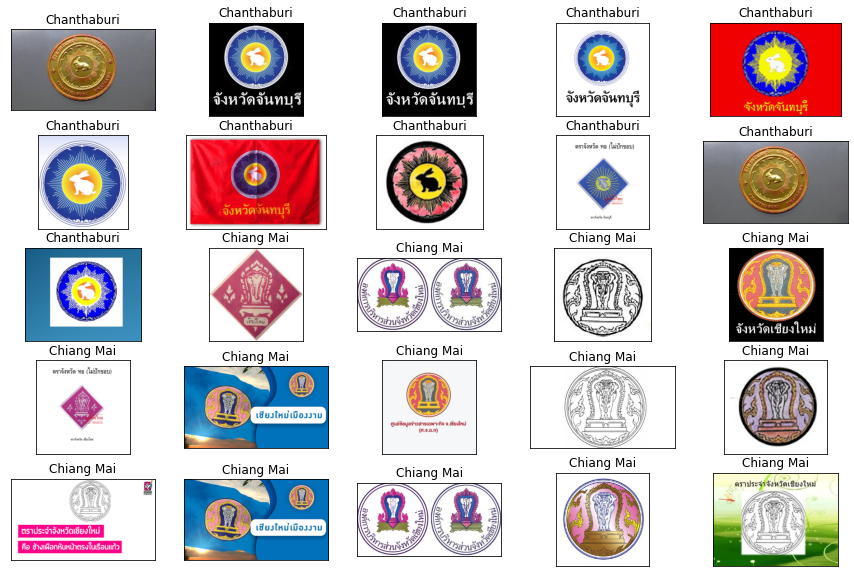

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(dataframe.images[i]))
    ax.set_title(dataframe.labels[i])
plt.show()

In [13]:
shuffled_dataframe = dataframe.sample(frac = 1)

In [14]:
all_train, test = train_test_split(shuffled_dataframe, test_size=0.2, random_state=42)
train, val = train_test_split(all_train, test_size=0.3, random_state=42)

In [15]:
test.head()

,images,labels
1934,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Ratchaburi
1052,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Nakhon Phanom
1514,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Trat
767,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Satun
2063,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Satun


In [16]:
training_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
training_generator = training_data_gen.flow_from_dataframe(dataframe=train,
                                                          x_col='images', y_col='labels',
                                                          target_size=(224, 224),
                                                          color_mode='rgb',
                                                          class_mode='categorical',
                                                          batch_size=64)

val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
validation_generator = val_data_gen.flow_from_dataframe(dataframe=val,
                                                       x_col='images', y_col='labels',
                                                       target_size=(224, 224),
                                                       color_mode='rgb',
                                                       class_mode='categorical',
                                                       batch_size=64)

test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
test_generator = test_data_gen.flow_from_dataframe(dataframe=test,
                                                  x_col='images', y_col='labels',
                                                  target_size=(224, 224),
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  batch_size=64,
                                                  shuffle=False)

Found 1192 validated image filenames belonging to 77 classes.
Found 511 validated image filenames belonging to 77 classes.
Found 426 validated image filenames belonging to 77 classes.


In [17]:
label_map = test_generator.class_indices
label_map

{'Amnat Charoen': 0,
 'Ang Thong': 1,
 'Bangkok': 2,
 'Bueng Kan': 3,
 'Buri Ram': 4,
 'Chachoengsao': 5,
 'Chai Nat': 6,
 'Chaiyaphum': 7,
 'Chanthaburi': 8,
 'Chiang Mai': 9,
 'Chiang Rai': 10,
 'Chon Buri': 11,
 'Chumphon': 12,
 'Kalasin': 13,
 'Kamphaeng Phet': 14,
 'Kanchanaburi': 15,
 'Khon Kaen': 16,
 'Krabi': 17,
 'Lampang': 18,
 'Lamphun': 19,
 'Loei': 20,
 'Lop Buri': 21,
 'Mae Hong Son': 22,
 'Maha Sarakham': 23,
 'Mukdahan': 24,
 'Nakhon Nayok': 25,
 'Nakhon Pathom': 26,
 'Nakhon Phanom': 27,
 'Nakhon Ratchasima': 28,
 'Nakhon Sawan': 29,
 'Nakhon Si Thammarat': 30,
 'Nan': 31,
 'Narathiwat': 32,
 'Nong Bua Lam Phu': 33,
 'Nong Khai': 34,
 'Nonthaburi': 35,
 'Pathum Thani': 36,
 'Pattani': 37,
 'Phang Nga': 38,
 'Phatthalung': 39,
 'Phayao': 40,
 'Phetchabun': 41,
 'Phetchaburi': 42,
 'Phichit': 43,
 'Phitsanulok': 44,
 'Phra Nakhon Si Ayutthaya': 45,
 'Phrae': 46,
 'Phuket': 47,
 'Prachin Buri': 48,
 'Prachuap Khiri Khan': 49,
 'Ranong': 50,
 'Ratchaburi': 51,
 'Rayong': 5

In [18]:
test_generator.class_indices.keys()

dict_keys(['Amnat Charoen', 'Ang Thong', 'Bangkok', 'Bueng Kan', 'Buri Ram', 'Chachoengsao', 'Chai Nat', 'Chaiyaphum', 'Chanthaburi', 'Chiang Mai', 'Chiang Rai', 'Chon Buri', 'Chumphon', 'Kalasin', 'Kamphaeng Phet', 'Kanchanaburi', 'Khon Kaen', 'Krabi', 'Lampang', 'Lamphun', 'Loei', 'Lop Buri', 'Mae Hong Son', 'Maha Sarakham', 'Mukdahan', 'Nakhon Nayok', 'Nakhon Pathom', 'Nakhon Phanom', 'Nakhon Ratchasima', 'Nakhon Sawan', 'Nakhon Si Thammarat', 'Nan', 'Narathiwat', 'Nong Bua Lam Phu', 'Nong Khai', 'Nonthaburi', 'Pathum Thani', 'Pattani', 'Phang Nga', 'Phatthalung', 'Phayao', 'Phetchabun', 'Phetchaburi', 'Phichit', 'Phitsanulok', 'Phra Nakhon Si Ayutthaya', 'Phrae', 'Phuket', 'Prachin Buri', 'Prachuap Khiri Khan', 'Ranong', 'Ratchaburi', 'Rayong', 'Roi Et', 'Sa Kaeo', 'Sakon Nakhon', 'Samut Prakan', 'Samut Sakhon', 'Samut Songkhram', 'Saraburi', 'Satun', 'Si Sa Ket', 'Sing Buri', 'Songkhla', 'Sukhothai', 'Suphan Buri', 'Surat Thani', 'Surin', 'Tak', 'Trang', 'Trat', 'Ubon Ratchathani'

# Import Model and Finetuning

In [19]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58889256/58889256 [==============================] - 1s 0us/step


In [20]:
for layer in base_model.layers:
    layer.trainable = False
    
from tensorflow.keras import layers 
from tensorflow.keras import Model 

In [21]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

x = layers.Dense(77, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])

In [22]:
vgghist = model.fit(training_generator, validation_data = validation_generator, epochs = 50)

Epoch 1/50
 1/19 [>.............................] - ETA: 17:01 - loss: 4.7676 - acc: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19/19 [==============================] - 1110s 59s/step - loss: 4.5232 - acc: 0.0193 - val_loss: 4.2525 - val_acc: 0.0235
Epoch 2/50
19/19 [==============================] - 36s 2s/step - loss: 4.2338 - acc: 0.0411 - val_loss: 4.1463 - val_acc: 0.0802
Epoch 3/50
19/19 [==============================] - 36s 2s/step - loss: 4.1024 - acc: 0.0763 - val_loss: 4.0432 - val_acc: 0.0861
Epoch 4/50
19/19 [==============================] - 35s 2s/step - loss: 4.0051 - acc: 0.0914 - val_loss: 3.9000 - val_acc: 0.1957
Epoch 5/50
19/19 [==============================] - 35s 2s/step - loss: 3.8620 - acc: 0.1258 - val_loss: 3.7990 - val_acc: 0.1879
Epoch 6/50
19/19 [==============================] - 36s 2s/step - loss: 3.7273 - acc: 0.1594 - val_loss: 3.6722 - val_acc: 0.2290
Epoch 7/50
19/19 [==============================] - 35s 2s/step - loss: 3.5698 - acc: 0.1804 - val_loss: 3.5660 - val_acc: 0.2564
Epoch 8/50
19/19 [==============================] - 36s 2s/step - loss: 3.4435 - acc: 0.2173 - val

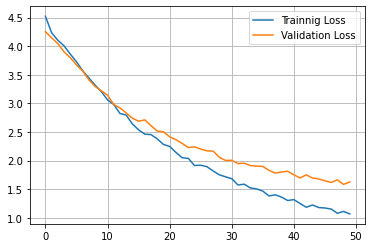

In [23]:
model_train_loss = vgghist.history['loss']
model_val_loss = vgghist.history['val_loss']

plt.plot(vgghist.epoch, model_train_loss, label='Trainnig Loss')
plt.plot(vgghist.epoch, model_val_loss, label='Validation Loss')
plt.grid(True)
plt.legend()

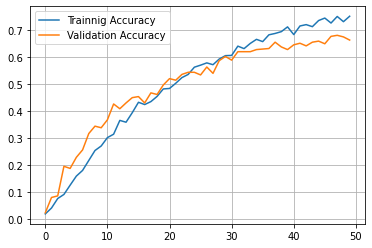

In [24]:
train_acc = vgghist.history['acc']
val_acc = vgghist.history['val_acc']

plt.plot(vgghist.epoch, train_acc, label='Trainnig Accuracy')
plt.plot(vgghist.epoch, val_acc, label='Validation Accuracy')
plt.grid(True)
plt.legend()

In [25]:
model.evaluate(test_generator)

7/7 [==============================] - 240s 40s/step - loss: 1.4535 - acc: 0.6854


[1.4534590244293213, 0.68544602394104]

In [26]:
# Switch Dict and Value
label_map_switch = {}
for k, v in label_map.items():
    label_map_switch[v] = k
label_map_switch

{0: 'Amnat Charoen',
 1: 'Ang Thong',
 2: 'Bangkok',
 3: 'Bueng Kan',
 4: 'Buri Ram',
 5: 'Chachoengsao',
 6: 'Chai Nat',
 7: 'Chaiyaphum',
 8: 'Chanthaburi',
 9: 'Chiang Mai',
 10: 'Chiang Rai',
 11: 'Chon Buri',
 12: 'Chumphon',
 13: 'Kalasin',
 14: 'Kamphaeng Phet',
 15: 'Kanchanaburi',
 16: 'Khon Kaen',
 17: 'Krabi',
 18: 'Lampang',
 19: 'Lamphun',
 20: 'Loei',
 21: 'Lop Buri',
 22: 'Mae Hong Son',
 23: 'Maha Sarakham',
 24: 'Mukdahan',
 25: 'Nakhon Nayok',
 26: 'Nakhon Pathom',
 27: 'Nakhon Phanom',
 28: 'Nakhon Ratchasima',
 29: 'Nakhon Sawan',
 30: 'Nakhon Si Thammarat',
 31: 'Nan',
 32: 'Narathiwat',
 33: 'Nong Bua Lam Phu',
 34: 'Nong Khai',
 35: 'Nonthaburi',
 36: 'Pathum Thani',
 37: 'Pattani',
 38: 'Phang Nga',
 39: 'Phatthalung',
 40: 'Phayao',
 41: 'Phetchabun',
 42: 'Phetchaburi',
 43: 'Phichit',
 44: 'Phitsanulok',
 45: 'Phra Nakhon Si Ayutthaya',
 46: 'Phrae',
 47: 'Phuket',
 48: 'Prachin Buri',
 49: 'Prachuap Khiri Khan',
 50: 'Ranong',
 51: 'Ratchaburi',
 52: 'Rayong

In [27]:
predictions = model.predict(test_generator)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability
predicted_label_batch =list(map(label_map_switch.get, pred_labels.tolist()))

7/7 [==============================] - 5s 725ms/step


In [28]:
test_dup = test.copy()
test_dup = test_dup.reset_index(drop=True)
test_dup["predict"] = pd.DataFrame(predicted_label_batch)
test_dup.head()

,images,labels,predict
0,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Ratchaburi,Ratchaburi
1,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Nakhon Phanom,Nakhon Phanom
2,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Trat,Trat
3,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Satun,Sa Kaeo
4,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Satun,Satun


In [29]:
y_pred = [label_map_switch[k] for k in pred_labels]
print(classification_report(test.labels, y_pred))

                          precision    recall  f1-score   support

           Amnat Charoen       0.50      0.33      0.40         3
               Ang Thong       0.00      0.00      0.00         1
                 Bangkok       1.00      0.83      0.91         6
               Bueng Kan       1.00      0.43      0.60         7
                Buri Ram       0.67      0.67      0.67         3
            Chachoengsao       0.67      0.44      0.53         9
                Chai Nat       0.25      0.50      0.33         2
              Chaiyaphum       0.57      1.00      0.73         4
             Chanthaburi       0.83      0.83      0.83         6
              Chiang Mai       1.00      0.86      0.92         7
              Chiang Rai       1.00      0.75      0.86         8
               Chon Buri       0.43      0.86      0.57         7
                Chumphon       1.00      0.50      0.67         4
                 Kalasin       1.00      1.00      1.00         1
         

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


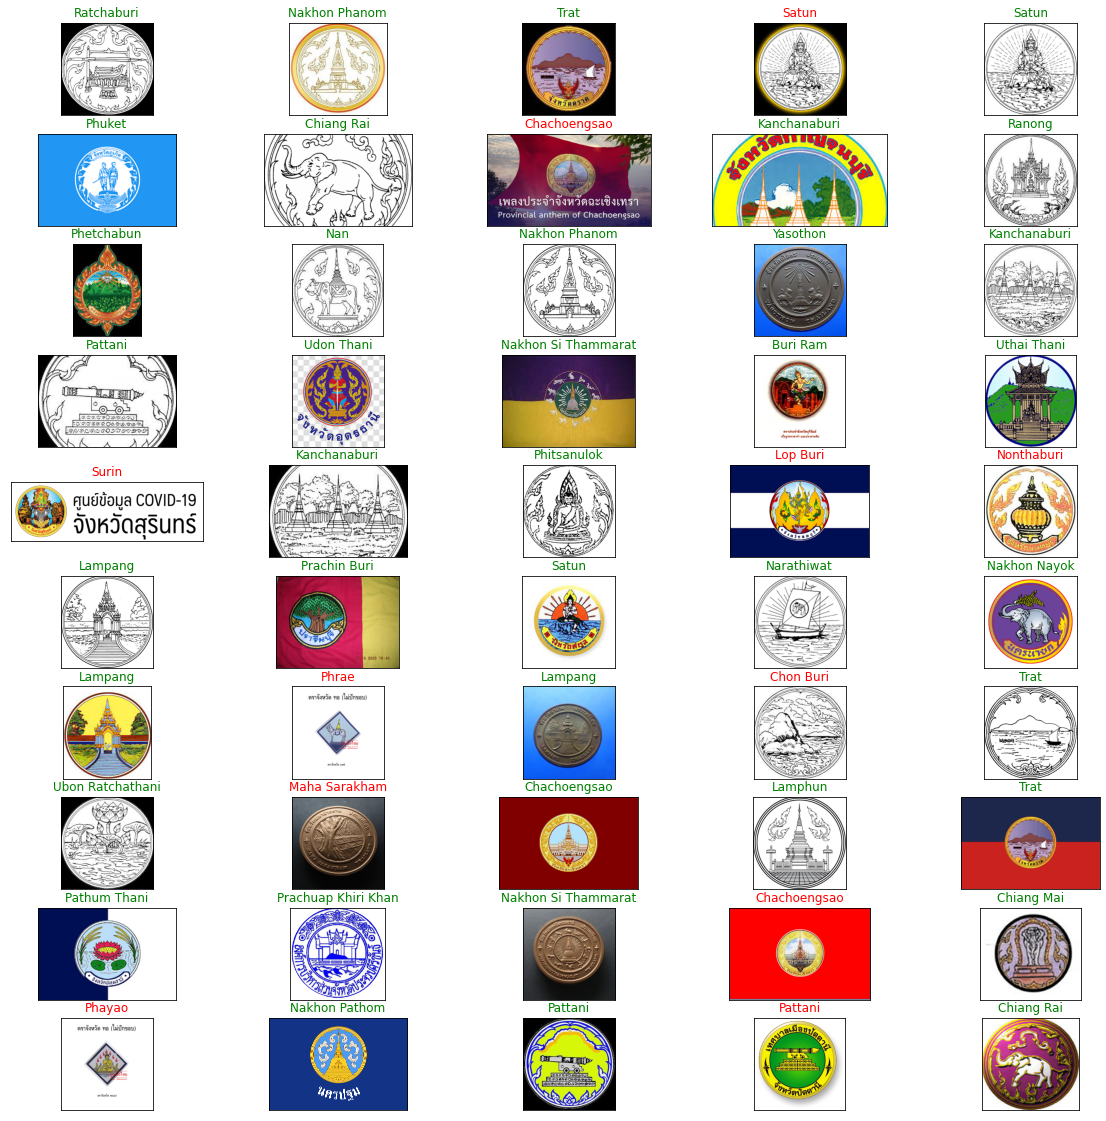

In [30]:
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(20,20), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_dup.images[i]))
    color = "green" if test_dup.predict[i] == test_dup.labels[i] else "red"
    ax.set_title(test_dup.labels[i],color=color)
plt.show()

# Base Model

In [31]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [32]:
for layer in base_model.layers:
    layer.trainable = True
    
from tensorflow.keras import layers 
from tensorflow.keras import Model 

In [33]:
y = layers.Flatten()(base_model.output)
y = layers.Dense(77, activation='softmax')(y)
base_model = tf.keras.models.Model(base_model.input, y)
base_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])

In [34]:
basehist = base_model.fit(training_generator, validation_data = validation_generator, epochs = 50)

Epoch 1/50
15/19 [======================>.......] - ETA: 7s - loss: 4.4404 - acc: 0.0150

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19/19 [==============================] - 52s 2s/step - loss: 4.4227 - acc: 0.0143 - val_loss: 4.3484 - val_acc: 0.0117
Epoch 2/50
19/19 [==============================] - 39s 2s/step - loss: 4.3401 - acc: 0.0117 - val_loss: 4.3539 - val_acc: 0.0039
Epoch 3/50
19/19 [==============================] - 39s 2s/step - loss: 4.3277 - acc: 0.0168 - val_loss: 4.3485 - val_acc: 0.0117
Epoch 4/50
19/19 [==============================] - 39s 2s/step - loss: 4.3097 - acc: 0.0193 - val_loss: 4.3436 - val_acc: 0.0274
Epoch 5/50
19/19 [==============================] - 40s 2s/step - loss: 4.3003 - acc: 0.0168 - val_loss: 4.3419 - val_acc: 0.0137
Epoch 6/50
19/19 [==============================] - 40s 2s/step - loss: 4.2978 - acc: 0.0310 - val_loss: 4.3580 - val_acc: 0.0137
Epoch 7/50
19/19 [==============================] - 39s 2s/step - loss: 4.2668 - acc: 0.0218 - val_loss: 4.3399 - val_acc: 0.0117
Epoch 8/50
19/19 [==============================] - 39s 2s/step - loss: 4.2548 - acc: 0.0260 - val_lo

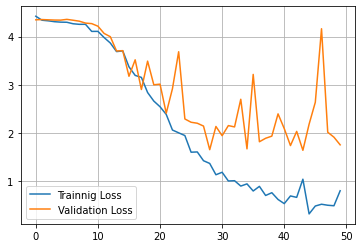

In [35]:
base_model_train_loss = basehist.history['loss']
base_model_val_loss = basehist.history['val_loss']

plt.plot(basehist.epoch, base_model_train_loss, label='Trainnig Loss')
plt.plot(basehist.epoch, base_model_val_loss, label='Validation Loss')
plt.grid(True)
plt.legend()

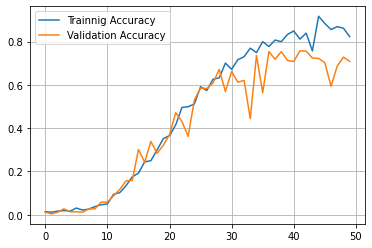

In [36]:
base_model_train_acc =basehist.history['acc']
base_model_val_acc = basehist.history['val_acc']

plt.plot(basehist.epoch, base_model_train_acc, label='Trainnig Accuracy')
plt.plot(basehist.epoch, base_model_val_acc, label='Validation Accuracy')
plt.grid(True)
plt.legend()

In [37]:
base_model.evaluate(test_generator)

7/7 [==============================] - 5s 699ms/step - loss: 1.3794 - acc: 0.7347


[1.3793751001358032, 0.7347418069839478]

In [38]:
predictions2 = base_model.predict(test_generator)     # Vector of probabilities
pred_labels2 = np.argmax(predictions2, axis = 1) # We take the highest probability
predicted2_label_batch =list(map(label_map_switch.get, pred_labels2.tolist()))

7/7 [==============================] - 7s 958ms/step


In [39]:
test2_dup = test.copy()
test2_dup = test2_dup.reset_index(drop=True)
test2_dup["predict"] = pd.DataFrame(predicted2_label_batch)
test2_dup.head()

,images,labels,predict
0,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Ratchaburi,Nan
1,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Nakhon Phanom,Nakhon Phanom
2,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Trat,Trat
3,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Satun,Sa Kaeo
4,/content/drive/MyDrive/Colab Notebooks/CNN/dat...,Satun,Sa Kaeo


In [40]:
# Switch Dict and Value
label_map_switch = {}
for k, v in label_map.items():
    label_map_switch[v] = k
label_map_switch

{0: 'Amnat Charoen',
 1: 'Ang Thong',
 2: 'Bangkok',
 3: 'Bueng Kan',
 4: 'Buri Ram',
 5: 'Chachoengsao',
 6: 'Chai Nat',
 7: 'Chaiyaphum',
 8: 'Chanthaburi',
 9: 'Chiang Mai',
 10: 'Chiang Rai',
 11: 'Chon Buri',
 12: 'Chumphon',
 13: 'Kalasin',
 14: 'Kamphaeng Phet',
 15: 'Kanchanaburi',
 16: 'Khon Kaen',
 17: 'Krabi',
 18: 'Lampang',
 19: 'Lamphun',
 20: 'Loei',
 21: 'Lop Buri',
 22: 'Mae Hong Son',
 23: 'Maha Sarakham',
 24: 'Mukdahan',
 25: 'Nakhon Nayok',
 26: 'Nakhon Pathom',
 27: 'Nakhon Phanom',
 28: 'Nakhon Ratchasima',
 29: 'Nakhon Sawan',
 30: 'Nakhon Si Thammarat',
 31: 'Nan',
 32: 'Narathiwat',
 33: 'Nong Bua Lam Phu',
 34: 'Nong Khai',
 35: 'Nonthaburi',
 36: 'Pathum Thani',
 37: 'Pattani',
 38: 'Phang Nga',
 39: 'Phatthalung',
 40: 'Phayao',
 41: 'Phetchabun',
 42: 'Phetchaburi',
 43: 'Phichit',
 44: 'Phitsanulok',
 45: 'Phra Nakhon Si Ayutthaya',
 46: 'Phrae',
 47: 'Phuket',
 48: 'Prachin Buri',
 49: 'Prachuap Khiri Khan',
 50: 'Ranong',
 51: 'Ratchaburi',
 52: 'Rayong

In [41]:
y_pred2 = [label_map_switch[k] for k in pred_labels2]
print(classification_report(test.labels, y_pred2))

                          precision    recall  f1-score   support

           Amnat Charoen       1.00      1.00      1.00         3
               Ang Thong       0.00      0.00      0.00         1
                 Bangkok       1.00      0.83      0.91         6
               Bueng Kan       1.00      0.71      0.83         7
                Buri Ram       1.00      1.00      1.00         3
            Chachoengsao       1.00      0.56      0.71         9
                Chai Nat       0.00      0.00      0.00         2
              Chaiyaphum       0.67      1.00      0.80         4
             Chanthaburi       0.83      0.83      0.83         6
              Chiang Mai       0.88      1.00      0.93         7
              Chiang Rai       1.00      0.88      0.93         8
               Chon Buri       1.00      0.57      0.73         7
                Chumphon       0.60      0.75      0.67         4
                 Kalasin       1.00      1.00      1.00         1
         

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


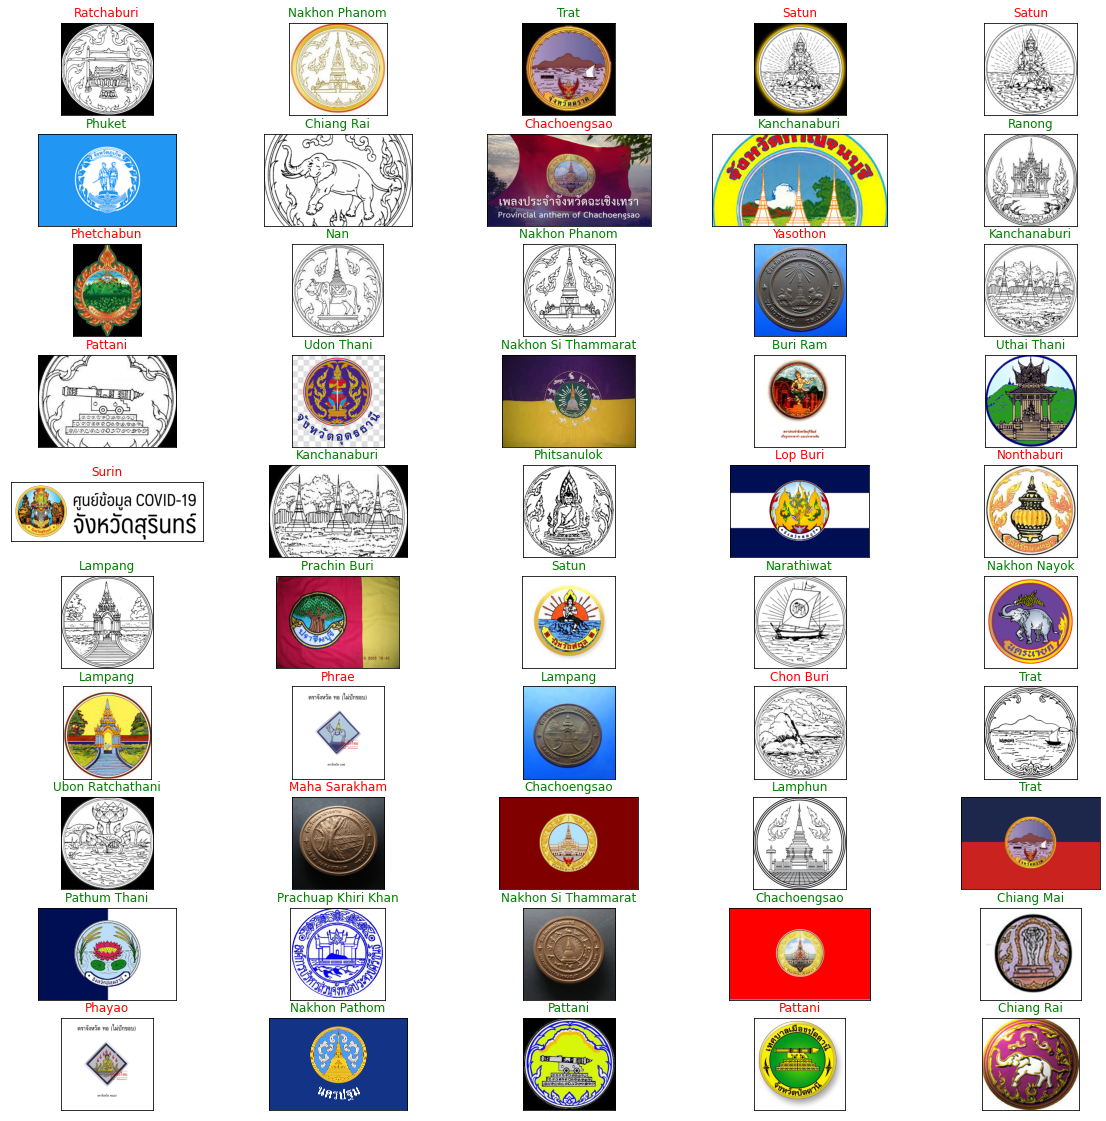

In [42]:
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(20,20), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test2_dup.images[i]))
    color = "green" if test2_dup.predict[i] == test2_dup.labels[i] else "red"
    ax.set_title(test2_dup.labels[i],color=color)
plt.show()